# Supernova cosmology: inference with MCMC and HMC

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
import scipy.stats as ss
from cycler import cycler
from IPython.display import Math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/Supernova_MCMC_HMC/"
!mkdir -p $dir

In [3]:
# Plotting utilities
colorsDict = {
                  # Match pygtc up to v0.2.4
                  'blues_old' : ('#4c72b0','#7fa5e3','#b2d8ff'),
                  'greens_old' : ('#55a868','#88db9b','#bbffce'),
                  'yellows_old' : ('#f5964f','#ffc982','#fffcb5'),
                  'reds_old' : ('#c44e52','#f78185','#ffb4b8'),
                  'purples_old' : ('#8172b2','#b4a5e5','#37d8ff'),
                  # New color scheme, dark colors match matplotlib v2
                  'blues' : ('#1f77b4','#52aae7','#85ddff'),
                  'oranges' : ('#ff7f0e','#ffb241','#ffe574'),
                  'greens' : ('#2ca02c','#5fd35f','#92ff92'),
                  'reds' : ('#d62728','#ff5a5b','#ff8d8e'),
                  'purples' : ('#9467bd','#c79af0','#facdff'),
                  'browns' : ('#8c564b','#bf897e','#f2bcb1'),
                  'pinks' : ('#e377c2','#ffaaf5','#ffddff'),
                  'grays' : ('#7f7f7f','#b2b2b2','#e5e5e5'),
                  'yellows' : ('#bcbd22','#eff055','#ffff88'),
                  'cyans' : ('#17becf','#4af1ff','#7dffff'),
              }
defaultColorsOrder = ['blues', 'oranges','greens', 'reds', 'purples',
                        'browns', 'pinks', 'grays', 'yellows', 'cyans']
colors = [colorsDict[cs] for cs in defaultColorsOrder]

def get_contours(Z, nBins=30, confLevels=(.3173, .0455, .0027)):
    Z /= Z.sum()
    nContourLevels = len(confLevels)
    chainLevels = np.ones(nContourLevels+1)
    histOrdered = np.sort(Z.flat)
    histCumulative = np.cumsum(histOrdered)
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    for l in range(nContourLevels):
        # Find location of contour level in 1d histCumulative
        temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
        # Find "height" of contour level
        chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

    return chainLevels

def get_contours_from_samples(samples_x, samples_y, weights=None, nBins=30, confLevels=(.3173, .0455, .0027), smoothingKernel=1):
    from scipy.ndimage import gaussian_filter

    nContourLevels = len(confLevels)
    chainLevels = np.ones(nContourLevels+1)
    extents = np.empty(4)

    # These are needed to compute the contour levels
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    # Create 2d histogram
    if weights is None:
        weights = np.ones_like(samples_x)
    hist2d, xedges, yedges = np.histogram2d(
        samples_x, samples_y, weights=weights, bins=nBins)
    # image extent, needed below for contour lines
    extents = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Normalize
    hist2d = hist2d/np.sum(hist2d)
    # Cumulative 1d distribution
    histOrdered = np.sort(hist2d.flat)
    histCumulative = np.cumsum(histOrdered)

    # Compute contour levels (from low to high for technical reasons)
    for l in range(nContourLevels):
        # Find location of contour level in 1d histCumulative
        temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
        # Find "height" of contour level
        chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

    # Apply Gaussian smoothing
    contours = gaussian_filter(hist2d.T, sigma=smoothingKernel)

    xbins = (xedges[1:]+xedges[:-1])/2
    ybins = (yedges[1:]+yedges[:-1])/2

    return xbins, ybins, contours, chainLevels

## Theory (two-parameter problem)

In [4]:
def mu(z,Omega_m,h):
    this_D_L=D_L(z,Omega_m)
    if np.all(this_D_L > 0) and np.all(h > 0):
        return 25. - 5.*np.log10(h) + 5.*np.log10(this_D_L)
    else:
        return 0. # or raise ValueError("Invalid value for D_L")

def D_L(z,Omega_m):
    return 3000.*(1+z)*(eta(1.,Omega_m) - eta(1/(1.+z),Omega_m))

def eta(a,Omega_m):
    s = np.cbrt((1. - Omega_m) / Omega_m)
    if np.all(s**3+1.>=0):
        return 2*np.sqrt(s**3+1.) * (1/a**4 - 0.1540*s/a**3 + 0.4304*s**2/a**2 + 0.19097*s**3/a + 0.066941*s**4)**(-1/8.)
    else:
        return 0. # or raise ValueError("Invalid value for eta")

In [5]:
zs=np.linspace(1e-3,2,100)
h=0.7
mus={}
for Omega_m in [0.2,0.3,0.4,0.5]:
    mus[Omega_m]=mu(zs,Omega_m,h)

## Data and covariance matrix

In [6]:
zdata, data = np.loadtxt("data/jla_mub.txt",unpack=True)
cov = np.loadtxt("data/jla_mub_covmatrix.txt").reshape(31,31)

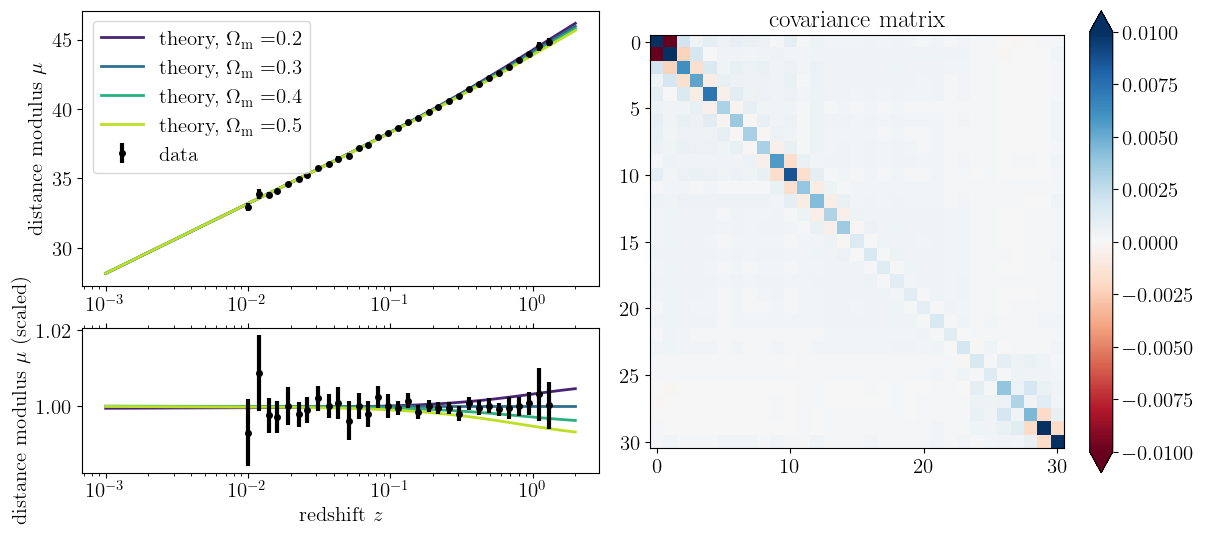

In [7]:
fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(wspace=0.1)
spec = fig.add_gridspec(2, 2, height_ratios=[1.9, 1])
ax0a = fig.add_subplot(spec[0, 0])
ax0b = fig.add_subplot(spec[1, 0], sharex=ax0a)
ax1 = fig.add_subplot(spec[:, 1])

ax0a.set_xscale('log')
ax0a.set_prop_cycle(cycler('color', plt.cm.viridis(np.linspace(0.1, 0.9, 4))))
for Omega_m in [0.2,0.3,0.4,0.5]:
    ax0a.plot(zs,mus[Omega_m],label="theory, $\Omega_\mathrm{m}=$"+str(Omega_m))
ax0a.errorbar(zdata,data,2*np.sqrt(np.diagonal(cov)),ls="",lw=3,marker="o",ms=4,color="black",label="data")

ax0a.set_ylabel("distance modulus $\mu$")
ax0a.legend(loc="best")
ax0b.set_xlabel("redshift $z$")

ax0b.set_prop_cycle(cycler('color', plt.cm.viridis(np.linspace(0.1, 0.9, 4))))
for Omega_m in [0.2,0.3,0.4,0.5]:
    ax0b.plot(zs,mus[Omega_m]/mus[0.3],label="theory, $\Omega_\mathrm{m}=$"+str(Omega_m))
ax0b.errorbar(zdata,data/mu(zdata,Omega_m=0.3,h=h),2*np.sqrt(np.diagonal(cov))/mu(zdata,Omega_m=0.3,h=h),ls="",lw=3,marker="o",ms=4,color="black",label="data")
ax0b.set_xlabel("redshift $z$")
ax0b.set_ylabel("distance modulus $\mu$ (scaled)")
ax0b.tick_params(axis='x', which='both', bottom=True, top=True)

im = ax1.imshow(cov,cmap="RdBu",vmin=-0.01,vmax=0.01,interpolation="nearest")
ax1.set_title("covariance matrix")
plt.colorbar(im, ax=ax1, extend="both")

plt.savefig(dir+'Supernova_theory_data_covmat_Omegam.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_theory_data_covmat_Omegam.png',dpi=300,bbox_inches="tight")
plt.show()

## Log-likelihood

In [8]:
def target_logpdf(theta,zdata,data,cov,Ncalls=-1):
    Omega_m, h = theta[0], theta[1]
    theory = mu(zdata, Omega_m, h)
    ans = ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [9]:
h=0.7
Omega_m=0.3
Math(f"\\mathrm{{log-likelihood}}(\\Omega_m={Omega_m:.1f}, h={h:.1f}) = {target_logpdf([Omega_m,h], zdata,data,cov):.3f}")

<IPython.core.display.Math object>

## Metropolis-Hastings sampler

In [10]:
def uniform_proposal_pdf(sigmaO, sigmah):
    return ss.uniform(loc=[-sigmaO*np.sqrt(3),-sigmah*np.sqrt(3)], scale=[2*sigmaO*np.sqrt(3),2*sigmah*np.sqrt(3)])

def gaussian_proposal_pdf(sigmaO, sigmah):
    return ss.multivariate_normal([0,0],[[sigmaO*sigmaO,0],[0,sigmah*sigmah]])

def proposal_pdf(sigmaO, sigmah):
#     return uniform_proposal_pdf(sigmaO, sigmah)
    return gaussian_proposal_pdf(sigmaO, sigmah)

In [11]:
def MH_sampler(Nsamp,theta_start,zdata,data,cov,proposal_sigma):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    theta=theta_start
    sigmaO, sigmah = proposal_sigma[0], proposal_sigma[1]
    for i in range(Nsamp-1):
        theta_p = theta + proposal_pdf(sigmaO, sigmah).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        log_a = target_logpdf(theta_p,zdata,data,cov) - target_logpdf(theta,zdata,data,cov)
        u = ss.uniform().rvs()
        if np.log(u) < log_a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
    return Naccepted, np.array(samples)

In [12]:
Nsamp=1000
Nburnin=100
proposal_sigma=np.array([0.015,0.02])
theta_start=np.array([0.5,0.5])
Naccepted, samples = MH_sampler(Nsamp,theta_start,zdata,data,cov,proposal_sigma)
fraction_accepted=float(Naccepted)/Nsamp

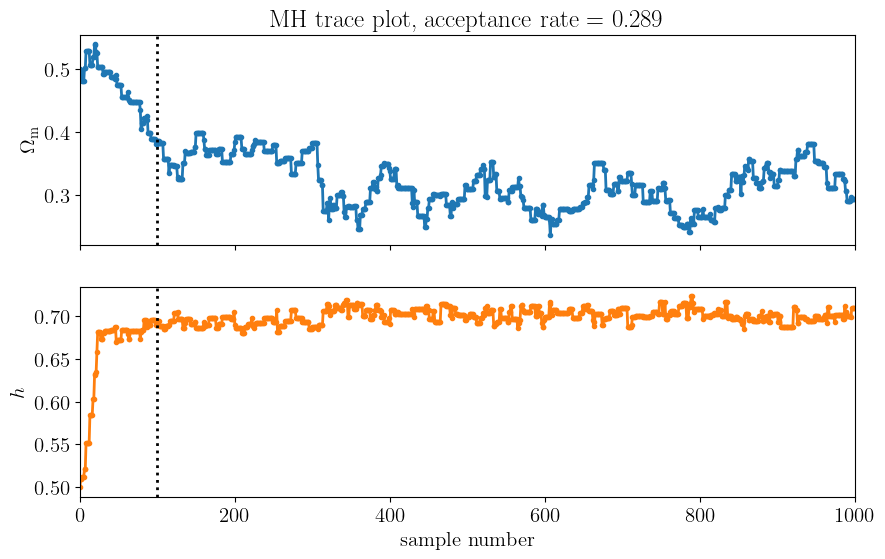

In [13]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6), sharex=True)
ax0.set_title("MH trace plot, acceptance rate = {:.3f}".format(fraction_accepted))
ax0.set_xlim(0,Nsamp)
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Nsamp),samples.T[0],marker='.',color='C0')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_xlim(0,Nsamp)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Nsamp),samples.T[1],marker='.',color='C1')
ax1.set_xlabel("sample number")
ax1.axvline(Nburnin,color='black',linestyle=':')

plt.savefig(dir+'Supernova_MH_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

In [14]:
fraction_accepted

0.289

## Markov Chain diagnostics

### 1- Step size

In [15]:
Nsamp2=1000
theta_start=np.array([0.5,0.5])

In [16]:
# Suitable step size
proposal_sigma_1=np.array([0.02,0.02])
Naccepted_1, samples_1 = MH_sampler(Nsamp2,theta_start,zdata,data,cov,proposal_sigma_1)
fraction_accepted_1=float(Naccepted_1)/Nsamp2

In [17]:
# Step size too large
proposal_sigma_2=np.array([0.08,0.08])
Naccepted_2, samples_2 = MH_sampler(Nsamp2,theta_start,zdata,data,cov,proposal_sigma_2)
fraction_accepted_2=float(Naccepted_2)/Nsamp2

In [18]:
# Step size too small
proposal_sigma_3=np.array([2e-3,2e-3])
Naccepted_3, samples_3 = MH_sampler(Nsamp2,theta_start,zdata,data,cov,proposal_sigma_3)
fraction_accepted_3=float(Naccepted_3)/Nsamp2

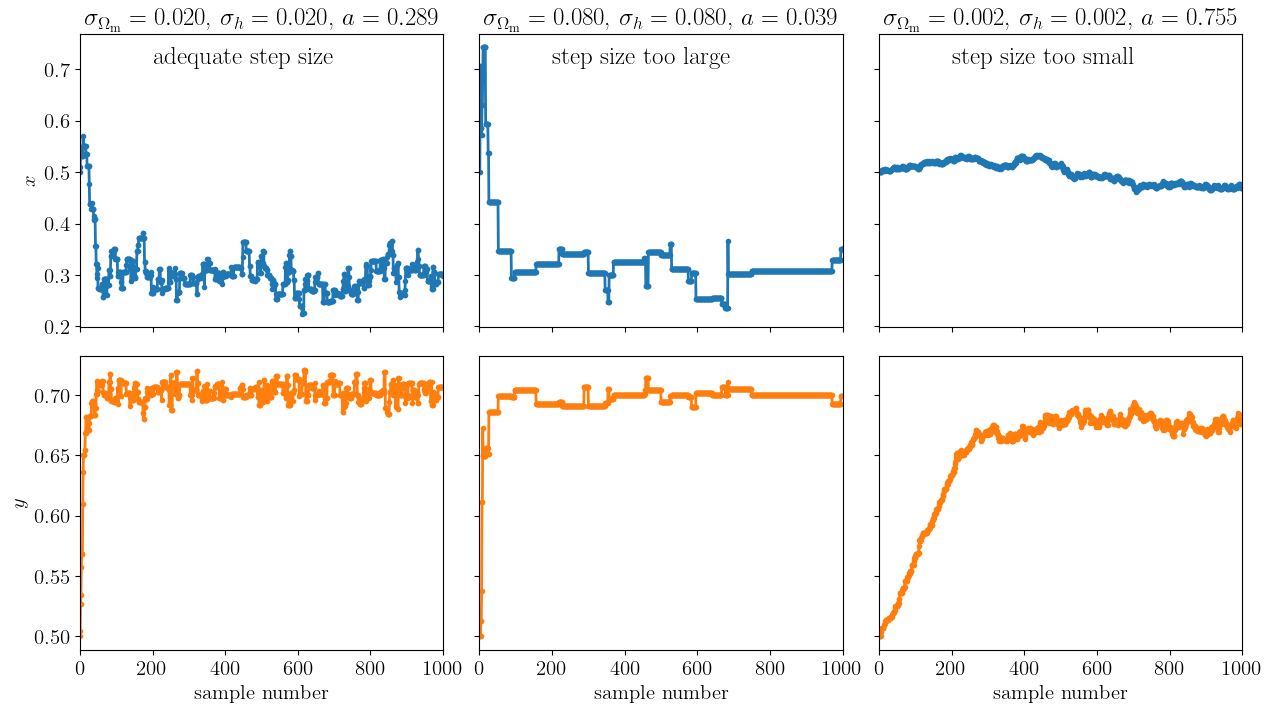

In [19]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8))

ax1a.set_ylabel("$x$")
ax1a.set_xlim(0,Nsamp2)
ax1a.plot(np.arange(Nsamp2),samples_1.T[0],marker='.',color='C0')
ax1a.set_title("$\\sigma_{{\\Omega_\\mathrm{{m}}}}={:.3f}$, $\\sigma_h={:.3f}$, $a={:.3f}$".format(proposal_sigma_1[0], proposal_sigma_1[1], fraction_accepted_1))
ax2a.set_xlim(0,Nsamp2)
ax2a.plot(np.arange(Nsamp2),samples_2.T[0],marker='.',color='C0')
ax2a.set_title("$\\sigma_{{\\Omega_\\mathrm{{m}}}}={:.3f}$, $\\sigma_h={:.3f}$, $a={:.3f}$".format(proposal_sigma_2[0], proposal_sigma_2[1], fraction_accepted_2))
ax3a.set_xlim(0,Nsamp2)
ax3a.plot(np.arange(Nsamp2),samples_3.T[0],marker='.',color='C0')
ax3a.set_title("$\\sigma_{{\\Omega_\\mathrm{{m}}}}={:.3f}$, $\\sigma_h={:.3f}$, $a={:.3f}$".format(proposal_sigma_3[0], proposal_sigma_3[1], fraction_accepted_3))

ax1b.set_ylabel("$y$")
ax1b.set_xlim(0,Nsamp2)
ax1b.set_xlabel("sample number")
ax1b.plot(np.arange(Nsamp2),samples_1.T[1],marker='.',color='C1')
ax2b.set_xlim(0,Nsamp2)
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Nsamp2),samples_2.T[1],marker='.',color='C1')
ax3b.set_xlim(0,Nsamp2)
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Nsamp2),samples_3.T[1],marker='.',color='C1')

ymin, ymax = ax1a.get_ylim()
ax1a.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=18)
ax2a.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=18)
ax3a.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=18)

f.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig(dir+'Supernova_MH_trace_plot_tuning.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_trace_plot_tuning.png',dpi=300,bbox_inches="tight")
plt.show()

### 2- Multiple chains, different starting points

In [20]:
Nsamp3=2000
Nburnin=200
proposal_sigma=np.array([0.025,0.02])
Nchains=5

In [21]:
# Run Nchains different chains starting at different positions in parameter space
chains = [MH_sampler(Nsamp3,theta_start,zdata,data,cov,proposal_sigma)
          for theta_start in np.column_stack((np.linspace(0.1,0.9,Nchains),np.linspace(0.1,0.9,Nchains)))]
chain = np.array([chains[j][1] for j in range(Nchains)])

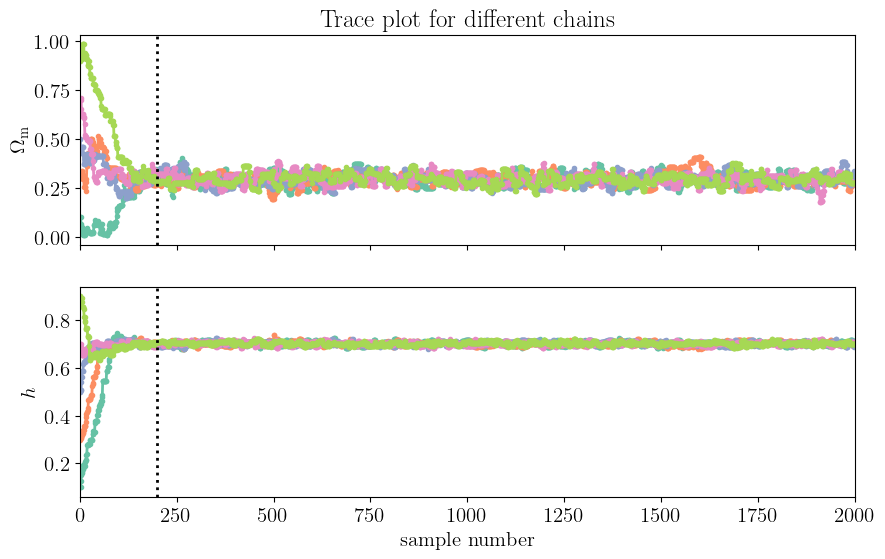

In [22]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax0.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax0.set_ylabel("$\\Omega_\mathrm{m}$")
ax0.set_title("Trace plot for different chains")
for c in range(Nchains):
    ax0.plot(np.arange(Nsamp3),chain[c].T[0],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax1.set_xlim(0,Nsamp3)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$h$")
for c in range(Nchains):
    ax1.plot(np.arange(Nsamp3),chain[c].T[1],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')

plt.savefig(dir+'Supernova_MH_trace_plot_different_starting_points.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_trace_plot_different_starting_points.png',dpi=300,bbox_inches="tight")
plt.show()

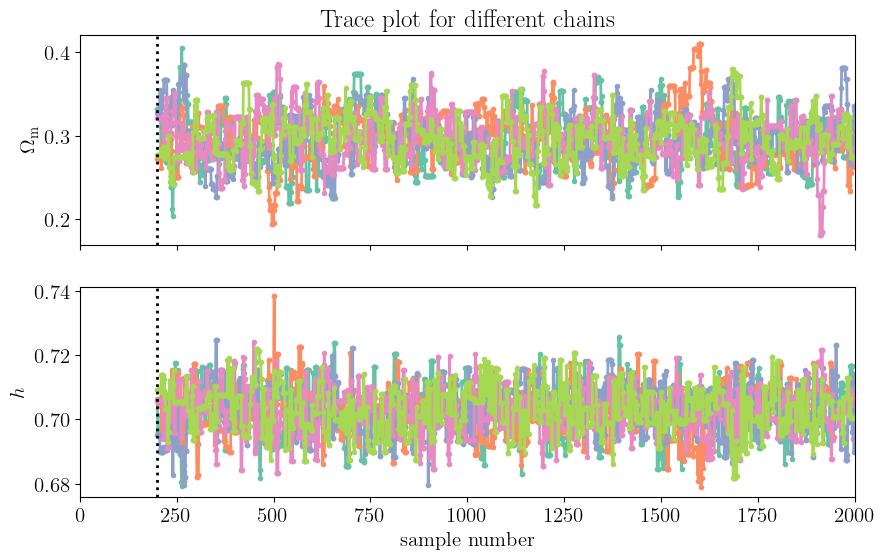

In [23]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax0.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax0.set_ylabel("$\\Omega_\mathrm{m}$")
ax0.set_title("Trace plot for different chains")
for c in range(Nchains):
    ax0.plot(np.arange(Nburnin,Nsamp3),chain[c].T[0][Nburnin:],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax1.set_xlim(0,Nsamp3)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$h$")
for c in range(Nchains):
    ax1.plot(np.arange(Nburnin,Nsamp3),chain[c].T[1][Nburnin:],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')

plt.savefig(dir+'Supernova_MH_trace_plot_different_starting_points_dropped_burnin.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_trace_plot_different_starting_points_dropped_burnin.png',dpi=300,bbox_inches="tight")
plt.show()

### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [24]:
def gelman_rubin(chain):
    # between chains variance
    Psi_dotj = np.mean(chain, axis=1)
    Psi_dotdot = np.mean(Psi_dotj, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((Psi_dotj - Psi_dotdot)**2, axis=0)

    # within chains variance
    sj2 = np.var(chain, axis=1, ddof=1)
    W = np.mean(sj2, axis=0)

    # estimators
    var_minus = W
    var_plus = (n - 1.) / n * W + 1. / n * B
    R_hat = np.sqrt(var_plus / var_minus)
    return R_hat

# The input array must have dimensions (nchains, nsamp, npars) = (m, n, npars).

In [25]:
gelman_rubin(chain)

array([1.02327119, 1.00829373])

## Likelihood surface

In [26]:
# Remove burn-in phase
chain_burn = np.array([chains[j][1][Nburnin:] for j in range(Nchains)])
chain_burn_flat = np.concatenate(chain_burn, axis=0)

In [27]:
# Means of parameters (h, Omega_m)
chain_burn.mean(axis=(0,1))

array([0.29600337, 0.70307885])

In [28]:
# Marginal standard deviations of parameters (h, Omega_m)
chain_burn.std(axis=(0,1))

array([0.02955513, 0.00708013])

In [29]:
# Covariance matrix of parameters (h, Omega_m)
np.cov(chain_burn_flat.T)

array([[ 8.73602717e-04, -1.24126013e-04],
       [-1.24126013e-04,  5.01337667e-05]])

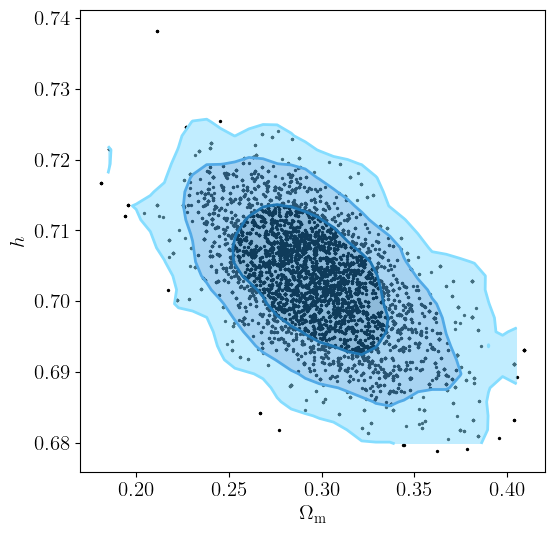

In [30]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(chain_burn_flat.T[0], chain_burn_flat.T[1], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours_from_samples(chain_burn_flat.T[0], chain_burn_flat.T[1])
nContourLevels = len(chainLevels)
ax.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1], alpha=0.5)
ax.contour(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1])
ax.set_xlabel("$\Omega_\mathrm{m}$")
ax.set_ylabel("$h$")

plt.savefig(dir+'Supernova_MH_likelihood_contours.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_likelihood_contours.png',dpi=300,bbox_inches="tight")
plt.show()

## Importance sampling

In [31]:
def prior_pdf(theta):
    Omega_m, h = theta[0], theta[1]
    h_mean=0.738
    h_std=0.024
    return ss.norm(loc=h_mean,scale=h_std).pdf(h)

In [32]:
prior_pdf([0.3,0.72])

12.54739300645018

In [33]:
weights=np.array([prior_pdf(chain_burn_flat[n]) for n in range(chain_burn_flat.shape[0])])
weights/=np.sum(weights)

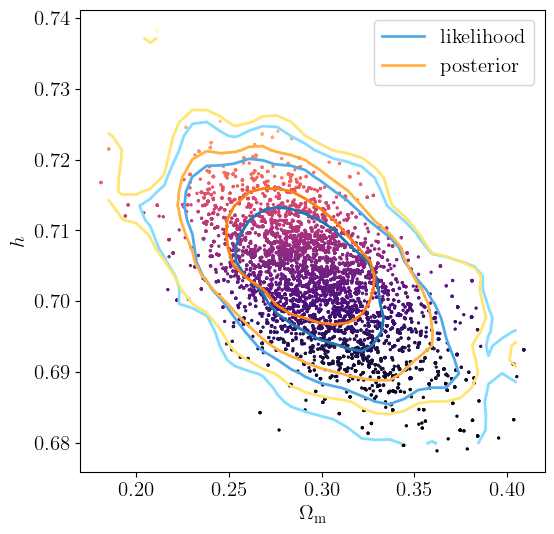

In [34]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(chain_burn_flat.T[0], chain_burn_flat.T[1], c=weights, s=2, cmap="magma")
xbins, ybins, contours_posterior, chainLevels = get_contours_from_samples(
    chain_burn_flat.T[0], chain_burn_flat.T[1], weights=weights)
nContourLevels = len(chainLevels)

cs0 = ax.contour(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1])
cs1 = ax.contour(xbins, ybins, contours_posterior, levels=chainLevels,
    colors=colors[1][:nContourLevels][::-1])
ax.set_xlabel("$\Omega_\mathrm{m}$")
ax.set_ylabel("$h$")

# Create proxy artists
proxy0 = mlines.Line2D([], [], color=cs0.collections[1].get_edgecolor()[0], label="likelihood")
proxy1 = mlines.Line2D([], [], color=cs1.collections[1].get_edgecolor()[0], label="posterior")
# Pass the proxy artists to the legend function
ax.legend(handles=[proxy0, proxy1])

plt.savefig(dir+'Supernova_importance_sampling_posterior_contours.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_importance_sampling_posterior_contours.png',dpi=300,bbox_inches="tight")
plt.show()

In [35]:
# Mean Omega_m,h with a flat prior
np.average(chain_burn_flat, axis=0)

array([0.29600337, 0.70307885])

In [36]:
# Mean Omega_m,h with the Gaussian prior on h
np.average(chain_burn_flat, weights=weights, axis=0)

array([0.28921288, 0.70584513])

## Hamiltonian Monte Carlo

### Potential

In [37]:
def psi(x,y,Ncalls=-1):
    # psi(x,y)=-ln(target_joint(x,y))
    ans = -target_logpdf([x,y],zdata,data,cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

# To get approximate derivatives, we approximate psi
# by a bivariate Gaussian with mean and covariance
# estimated from the MCMC result:
# psi = 1/2 * (theta-theta_m)^T C^{-1} (theta-theta_m)
# dpsi/dx = C^{-1} (theta-theta_m)[x]

theta_m = chain_burn.mean(axis=(0,1))
theta_C = np.cov(chain_burn_flat.T)
theta_P = np.linalg.inv(theta_C)

def approx_psi(x,y,Ncalls=-1):
    ans = 1/2.*(np.array([x,y])-theta_m).T.dot(theta_P).dot(np.array([x,y])-theta_m)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

def dpsi_dx(x,y,Ncalls=-1):
    ans = theta_P.dot(np.array([x,y])-theta_m)[0]
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
def dpsi_dy(x,y,Ncalls=-1):
    ans = theta_P.dot(np.array([x,y])-theta_m)[1]
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [38]:
xmin=0.15
xmax=0.55
ymin=0.65
ymax=0.74
x=np.linspace(xmin,xmax,100)
y=np.linspace(ymin,ymax,100)
X,Y=np.meshgrid(x,y)
Psi=[[psi(xi,yi) for xi in x] for yi in y]
APsi=[[approx_psi(xi,yi) for xi in x] for yi in y]
dPsi_dx=[[dpsi_dx(xi,yi) for xi in x] for yi in y]
dPsi_dy=[[dpsi_dy(xi,yi) for xi in x] for yi in y]

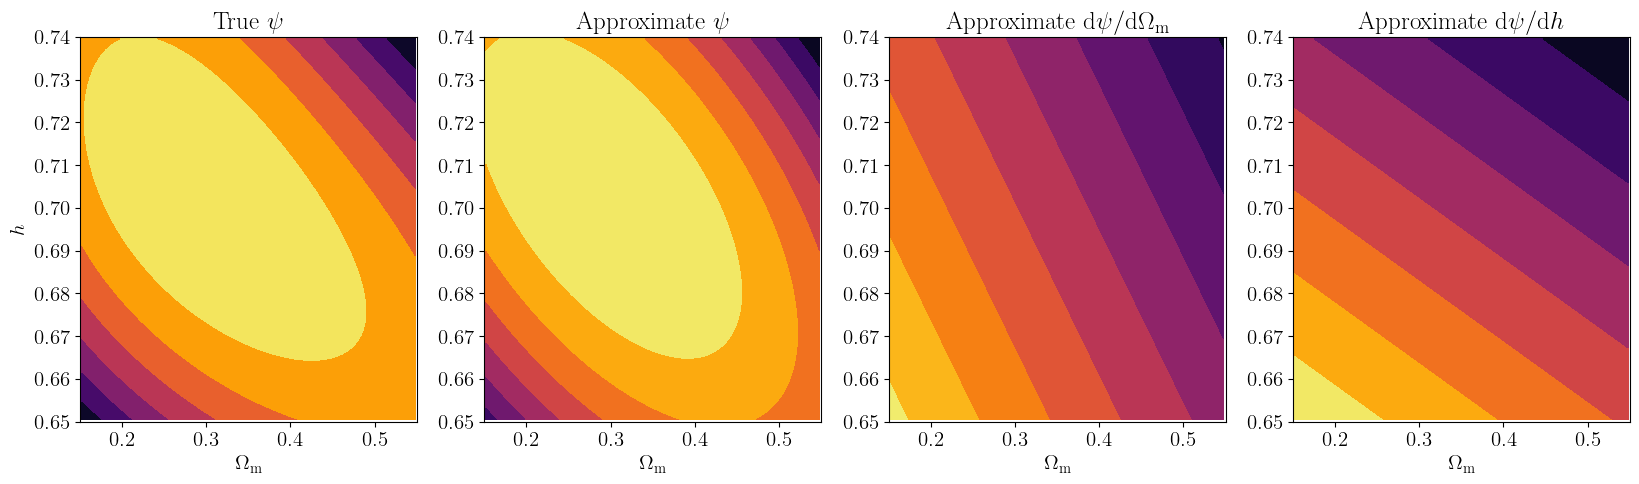

In [39]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,5))
fig.subplots_adjust(wspace=0.2)

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
ax0.set_xlabel("$\Omega_\mathrm{m}$")
ax0.set_ylabel("$h$")
ax0.set_title("True $\psi$")
ax0.contourf(Psi,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel("$\Omega_\mathrm{m}$")
ax1.set_title("Approximate $\psi$")
ax1.contourf(APsi,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.set_xlabel("$\Omega_\mathrm{m}$")
ax2.set_title("Approximate $\mathrm{d}\psi / \mathrm{d}\Omega_\mathrm{m}$")
ax2.contourf(dPsi_dx,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_xlabel("$\Omega_\mathrm{m}$")
ax3.set_title("Approximate $\mathrm{d}\psi / \mathrm{d}h$")
ax3.contourf(dPsi_dy,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')

plt.savefig(dir+'Supernova_HMC_psi.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_psi.png',dpi=300,bbox_inches="tight")
plt.show()

### Autocorrelation diagnostics

In [40]:
# Based on python code from the emcee tutorials, https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_power_of_2(n: int) -> int:
    """Smallest power of two ≥ n."""
    return 1 << (n - 1).bit_length() if n > 0 else 1

# 1D autocorrelation function
def autocorr_func_1d(x, norm=True):
    """
    Compute the 1D autocorrelation via FFT in O(N log N).
    If norm=True, normalize so acf[0] = 1.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    nfft = 2 * next_power_of_2(n)

    # real FFT
    f = np.fft.rfft(x - np.mean(x), n=nfft)
    ps = (f * f.conjugate()).real      # power spectrum
    acf = np.fft.irfft(ps, n=nfft)[:n]
    acf /= 2 * nfft

    # normalise
    if norm:
        if acf[0] <= 0:
            return 0 # or raise ValueError("Autocorrelation function is zero or negative at lag 0.")
        else:
            acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    """
    Return the first lag k for which k < c * tau_k fails.
    If none fail, return len(taus)-1.
    """
    k = np.arange(len(taus))
    mask = k < c * taus
    # find first index where mask is False
    idx = np.argmax(~mask)
    return idx if mask[idx] == False else len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(x, c: float = 5.0) -> float:
    """
    Estimate the integrated autocorrelation time following
    Goodman & Weare (2010), with window parameter c.
    """
    acf = autocorr_func_1d(x, norm=True)
    taus = 2.0 * np.cumsum(acf) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def N_eff(x) -> float:
    """
    Effective number of independent samples in x.
    Accepts input as either a list or a 1D numpy array.
    """
    x = np.asarray(x)
    tau = autocorr_gw2010(x)
    if tau <= 0:
        return 0 # or raise ValueError("Autocorrelation time is zero or negative.")
    return x.size / tau

### Sampler

In [41]:
def leapfrog_move(dpsi_dx,dpsi_dy,Ncalls_psi_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon):
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0
    # compute velocities
    p = np.array((p_x,p_y))
    v_x,v_y = InvMassMatrix.dot(p)
    # Drift: make full step in (x,y)
    new_x = x+epsilon*v_x
    new_y = y+epsilon*v_y
    # compute new gradient
    dpsidx, Ncalls_psi_current = dpsi_dx(new_x,new_y,Ncalls=Ncalls_psi_current)
    dpsidy, Ncalls_psi_current = dpsi_dy(new_x,new_y,Ncalls=Ncalls_psi_current)
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0

    return dpsidx,dpsidy,new_x,new_y,p_x,p_y,Ncalls_psi_current

def Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start):
    from math import floor
    InvMassMatrix=np.linalg.inv(MassMatrix)
    Naccepted=0
    x=x_start
    y=y_start
    samples_x=[x]
    samples_y=[y]
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Neff_x=[0]
    Neff_y=[0]
    for _ in range(Nsamp-1):
        # compute potential energy and gradient
        old_x = x
        old_y = y
        old_psi, Ncalls_psi_current = psi(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidx, Ncalls_psi_current = dpsi_dx(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidy, Ncalls_psi_current = dpsi_dy(old_x,old_y,Ncalls=Ncalls_psi_current)

        # randomly draw momenta
        p_x = ss.norm(0.,1.).rvs()
        p_y = ss.norm(0.,1.).rvs()
        p = np.array((p_x,p_y))

        # compute kinetic energy
        old_K = p.T.dot(InvMassMatrix).dot(p)/2.

        # compute Hamiltonian
        old_H = old_K + old_psi

        # do leapfrog integration steps
        Nsteps = 1+floor(ss.uniform.rvs()*Neval)
        for step in range(Nsteps):
            # draw stepsize
            epsilon = ss.uniform.rvs()*stepsize

            # call leapfrog move
            dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_psi_current = leapfrog_move(dpsi_dx,dpsi_dy,Ncalls_psi_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon)

        # compute new energy and Hamiltonian
        new_x=x; new_y=y
        new_psi = psi(new_x,new_y)
        p = np.array((p_x,p_y))
        new_K = p.T.dot(InvMassMatrix).dot(p)/2.
        new_H = new_K + new_psi
        dH = new_H - old_H

        # accept/reject new candidate x,y using the standard Metropolis-Hastings rule
        if(x<0.):
            accept=False
        else:
            if(dH<0.0):
                accept=True
            else:
                a = np.exp(-dH)
                u = np.random.uniform()
                if(u < a):
                    accept=True
                else:
                    accept=False

        if(accept):
            x=new_x
            y=new_y
            Naccepted+=1
        else:
            x=old_x
            y=old_y
        samples_x.append(x)
        samples_y.append(y)
        Ncalls_psi.append(Ncalls_psi_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))

    samples = np.column_stack((samples_x, samples_y))
    return Naccepted, samples, np.array(Ncalls_psi), np.array(Neff_x), np.array(Neff_y)

In [42]:
Nsamp=500
Omegam_start=0.40
h_start=0.60
Nburnin=20
MassMatrix=np.array([[60, 0.], [0., 80]])
Neval=12
stepsize=0.12
Naccepted,samples,Ncalls_psi_HMC,Neff_x_HMC,Neff_y_HMC=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,Omegam_start,h_start)

In [43]:
fraction_accepted=Naccepted/Nsamp
fraction_accepted

0.652

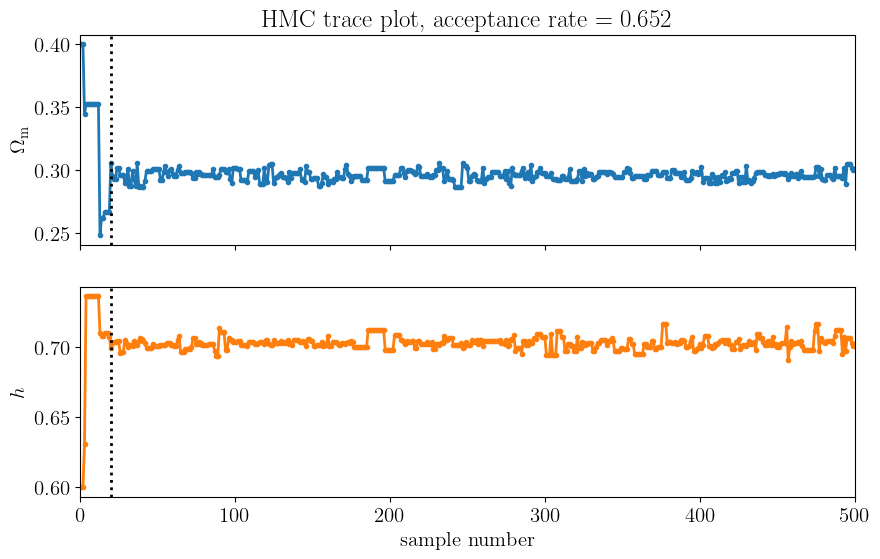

In [44]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6), sharex=True)
ax0.set_title("HMC trace plot, acceptance rate = {:.3f}".format(fraction_accepted))
ax0.set_xlim(0,Nsamp)
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Nsamp),samples.T[0],marker='.',color='C0')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_xlim(0,Nsamp)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Nsamp),samples.T[1],marker='.',color='C1')
ax1.set_xlabel("sample number")
ax1.axvline(Nburnin,color='black',linestyle=':')

plt.savefig(dir+'Supernova_HMC_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

### Tuning the Hamiltonian sampler

In [45]:
Nsampb=500
x_start=0.35
y_start=0.65
stepstd_1=0.01
N1,samples1b,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepstd_1,Nsampb,x_start,y_start)
fraction_accepted_1=N1/Nsampb

In [46]:
stepstd_2=0.1
N2,samples2b,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepstd_2,Nsampb,x_start,y_start)
fraction_accepted_2=N2/Nsampb

In [47]:
stepstd_3=0.5
N3,samples3b,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepstd_3,Nsampb,x_start,y_start)
fraction_accepted_3=N3/Nsampb

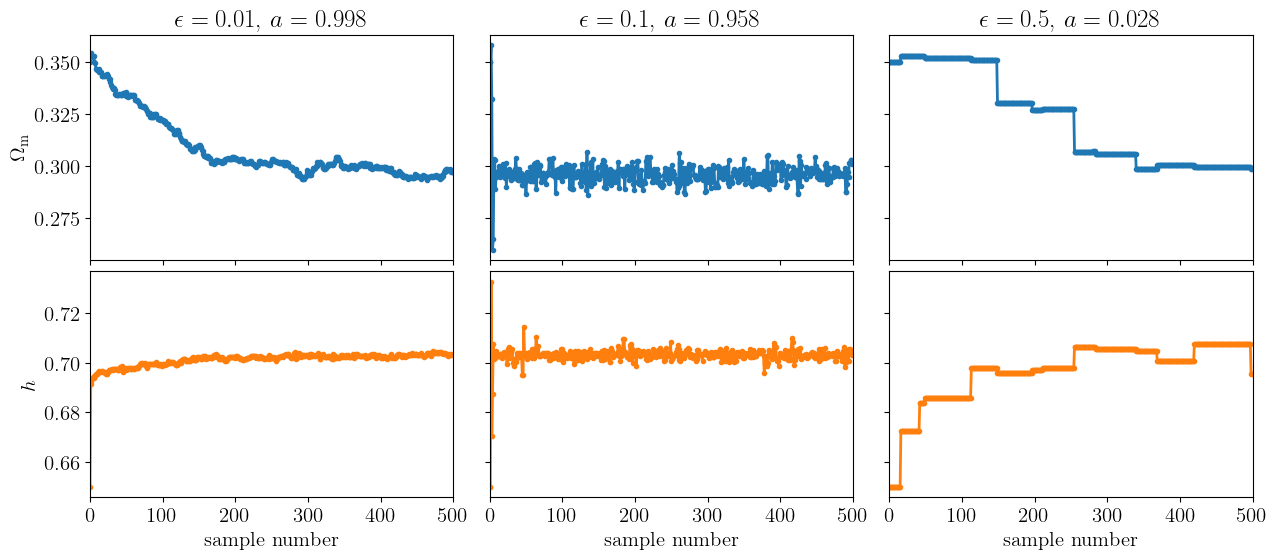

In [48]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,6))
f.subplots_adjust(wspace=0.1, hspace=0.05)
ax1a.set_ylabel("$\Omega_\mathrm{m}$")
ax1a.set_xlim([0,Nsampb])
ax1a.plot(np.arange(Nsampb),samples1b.T[0],marker='.',color='C0')
ax1a.set_title("$\\epsilon = "+str(stepstd_1)+"$, $a="+str(fraction_accepted_1)+"$")
ax2a.set_xlim([0,Nsampb])
ax2a.plot(np.arange(Nsampb),samples2b.T[0],marker='.',color='C0')
ax2a.set_title("$\epsilon = "+str(stepstd_2)+"$, $a="+str(fraction_accepted_2)+"$")
ax3a.set_xlim([0,Nsampb])
ax3a.plot(np.arange(Nsampb),samples3b.T[0],marker='.',color='C0')
ax3a.set_title("$\epsilon = "+str(stepstd_3)+"$, $a="+str(fraction_accepted_3)+"$")
ax1b.set_xlabel("sample number")
ax1b.set_ylabel("$h$")
ax1b.plot(np.arange(Nsampb),samples1b.T[1],marker='.',color='C1')
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Nsampb),samples2b.T[1],marker='.',color='C1')
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Nsampb),samples3b.T[1],marker='.',color='C1')
plt.savefig(dir+'Supernova_HMC_tuning_step_size.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_tuning_step_size.png',dpi=300,bbox_inches="tight")
plt.show()

In [49]:
Nsampc=500
Omegam_start=0.35
h_start=0.65
MassMatrix_1=np.array([[60, 0.], [0., 70]])
stepsize=0.1
N1,samples1c,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix_1,Neval,stepsize,Nsampc,Omegam_start,h_start)
fraction_accepted_1=float(N1)/Nsampc

In [50]:
MassMatrix_2=np.array([[0.6, 0.], [0., 70.]])
N2,samples2c,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix_2,Neval,stepsize,Nsampc,Omegam_start,h_start)
fraction_accepted_2=float(N2)/Nsampc

In [51]:
MassMatrix_3=np.array([[60., 0.], [0., 7.]])
N3,samples3c,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix_3,Neval,stepsize,Nsampc,Omegam_start,h_start)
fraction_accepted_3=float(N3)/Nsampc

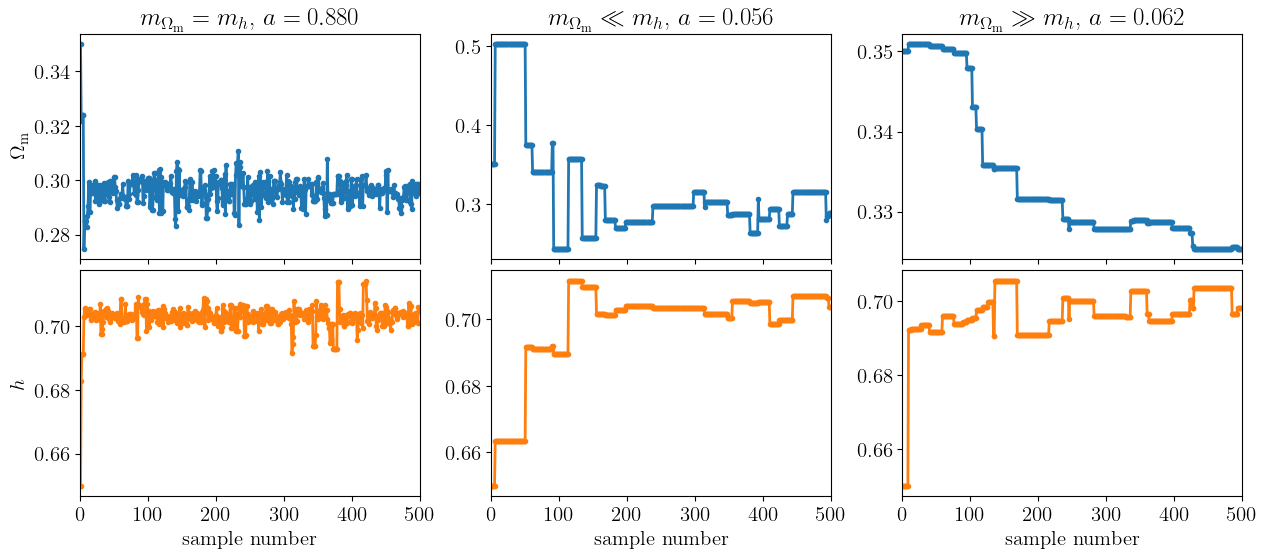

In [52]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', figsize=(15,6))
f.subplots_adjust(wspace=0.21, hspace=0.05)
ax1a.set_ylabel("$\\Omega_\mathrm{m}$")
ax1a.set_xlim([0,Nsampb])
ax1a.plot(np.arange(Nsampb),samples1c.T[0],marker='.',color='C0')
ax1a.set_title("$m_{{\\Omega_\\mathrm{{m}}}}=m_h$, $a={:.3f}".format(fraction_accepted_1)+"$")
ax2a.set_xlim([0,Nsampb])
ax2a.plot(np.arange(Nsampb),samples2c.T[0],marker='.',color='C0')
ax2a.set_title("$m_{{\\Omega_\\mathrm{{m}}}} \ll m_h$, $a={:.3f}".format(fraction_accepted_2)+"$")
ax3a.set_xlim([0,Nsampb])
ax3a.plot(np.arange(Nsampb),samples3c.T[0],marker='.',color='C0')
ax3a.set_title("$m_{{\\Omega_\\mathrm{{m}}}} \gg m_h$, $a={:.3f}".format(fraction_accepted_3)+"$")
ax1b.set_xlabel("sample number")
ax1b.set_ylabel("$h$")
ax1b.plot(np.arange(Nsampb),samples1c.T[1],marker='.',color='C1')
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Nsampb),samples2c.T[1],marker='.',color='C1')
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Nsampb),samples3c.T[1],marker='.',color='C1')
plt.savefig(dir+'Supernova_HMC_tuning_mass_matrix_1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_tuning_mass_matrix_1.png',dpi=300,bbox_inches="tight")
plt.show()

In [53]:
MassMatrix_4=np.array([[6e-1, 0.], [0., 7e-1]])
N4,samples4c,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix_4,Neval,stepsize,Nsampc,Omegam_start,h_start)
fraction_accepted_4=float(N4)/Nsampc

In [54]:
MassMatrix_5=np.array([[6000., 0.], [0., 7000.]])
N5,samples5c,_,_,_=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix_5,Neval,stepsize,Nsampc,Omegam_start,h_start)
fraction_accepted_5=float(N5)/Nsampc

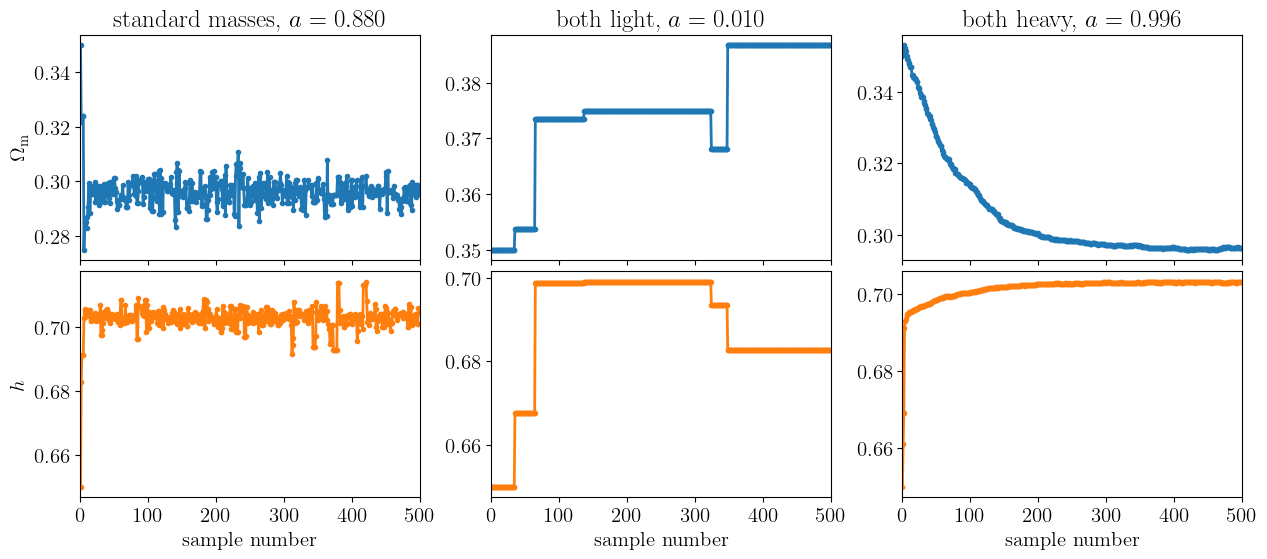

In [55]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', figsize=(15,6))
f.subplots_adjust(wspace=0.21, hspace=0.05)
ax1a.set_ylabel("$\\Omega_\mathrm{m}$")
ax1a.set_xlim([0,Nsampb])
ax1a.plot(np.arange(Nsampb),samples1c.T[0],marker='.',color='C0')
ax1a.set_title("standard masses, $a={:.3f}".format(fraction_accepted_1)+"$")
ax2a.set_xlim([0,Nsampb])
ax2a.plot(np.arange(Nsampb),samples4c.T[0],marker='.',color='C0')
ax2a.set_title("both light, $a={:.3f}".format(fraction_accepted_4)+"$")
ax3a.set_xlim([0,Nsampb])
ax3a.plot(np.arange(Nsampb),samples5c.T[0],marker='.',color='C0')
ax3a.set_title("both heavy, $a={:.3f}".format(fraction_accepted_5)+"$")
ax1b.set_xlabel("sample number")
ax1b.set_ylabel("$h$")
ax1b.plot(np.arange(Nsampb),samples1c.T[1],marker='.',color='C1')
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Nsampb),samples4c.T[1],marker='.',color='C1')
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Nsampb),samples5c.T[1],marker='.',color='C1')
plt.savefig(dir+'Supernova_HMC_tuning_mass_matrix_2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_tuning_mass_matrix_2.png',dpi=300,bbox_inches="tight")
plt.show()

### Comparison to MH: effective sample size per function evaluation

In [56]:
def MH_sampler_count(Nsamp,theta_start,zdata,data,cov,proposal_sigma):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    samples_x=list()
    samples_y=list()
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Neff_x=[0]
    Neff_y=[0]
    theta=theta_start
    sigmaO, sigmah = proposal_sigma[0], proposal_sigma[1]
    for i in range(Nsamp-1):
        theta_p = theta + proposal_pdf(sigmaO, sigmah).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        current_logpdf, Ncalls_psi_current = target_logpdf(theta_p,zdata,data,cov, Ncalls_psi_current)
        proposal_logpdf, Ncalls_psi_current = target_logpdf(theta,zdata,data,cov,Ncalls_psi_current)
        log_a = current_logpdf - proposal_logpdf
        u = ss.uniform().rvs()
        if np.log(u) < log_a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
        samples_x.append(theta[0])
        samples_y.append(theta[1])
        Ncalls_psi.append(Ncalls_psi_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))
    return Naccepted, np.array(samples), np.array(Ncalls_psi), np.array(Neff_x), np.array(Neff_y)

In [57]:
Nsamp=4000
proposal_sigma=np.array([0.01,0.01])
theta_start=np.array([0.5,0.5])
Naccepted, samples, Ncalls_psi_MH, Neff_x_MH, Neff_y_MH = MH_sampler_count(Nsamp,theta_start,zdata,data,cov,proposal_sigma)
fraction_accepted=float(Naccepted)/Nsamp
fraction_accepted

0.51575

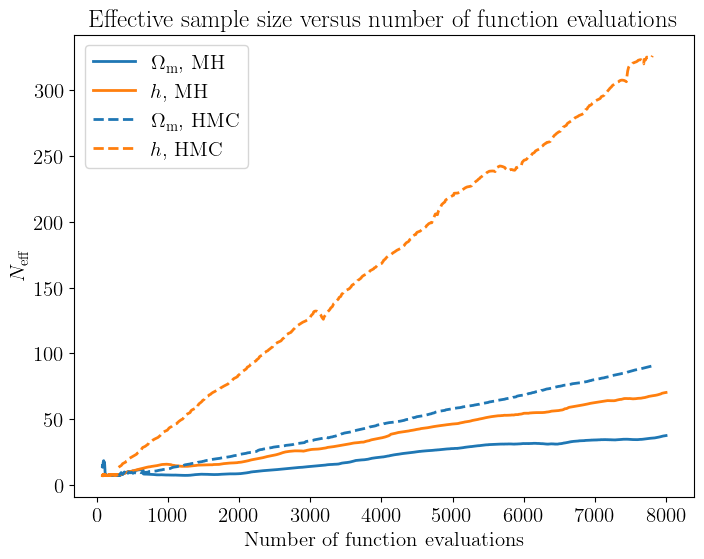

In [58]:
plt.figure(figsize=(8,6))
plt.plot(Ncalls_psi_MH[2*Nburnin:],Neff_x_MH[2*Nburnin:],color="C0",ls="-",label="$\Omega_\mathrm{m}$, MH")
plt.plot(Ncalls_psi_MH[2*Nburnin:],Neff_y_MH[2*Nburnin:],color="C1",ls="-",label="$h$, MH")
plt.plot(Ncalls_psi_HMC[Nburnin:],Neff_x_HMC[Nburnin:],color="C0",ls="--",label="$\Omega_\mathrm{m}$, HMC")
plt.plot(Ncalls_psi_HMC[Nburnin:],Neff_y_HMC[Nburnin:],color="C1",ls="--",label="$h$, HMC")
plt.xlabel("Number of function evaluations")
plt.ylabel("$N_\mathrm{eff}$")
plt.title("Effective sample size versus number of function evaluations")
plt.savefig(dir+'Supernova_HMC_ESS.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_HMC_ESS.png',dpi=300,bbox_inches="tight")
plt.legend(loc="best")

## Three-parameter problem

### Theory: exact calculation

In [59]:
def mu3(z,Omega_m,h,Omega_v):
    this_D_L = D_L3(z,Omega_m,Omega_v)
    if np.all(this_D_L > 0) and np.all(h > 0):
        return 25. - 5.*np.log10(h) + 5.*np.log10(this_D_L)
    else:
        return 0. # or raise ValueError("Invalid value for D_L")

def r(z,Omega_m,Omega_v):
    from scipy.integrate import quad

    Omega_k = 1 - Omega_m - Omega_v

    def integrand(z,Omega_m,Omega_k,Omega_v):
        return 1./np.sqrt(Omega_m*(1+z)**3 + Omega_k*(1+z)**2 + Omega_v)

    z = np.atleast_1d(z)
    I = np.array([quad(integrand, 0, zi, args=(Omega_m,Omega_k,Omega_v))[0] for zi in z])
    return I

def S_k(r,Omega_m,Omega_v):
    Omega_k = 1 - Omega_m - Omega_v
    if Omega_k>0:
        return np.sin(np.sqrt(np.abs(Omega_k))*r)
    elif Omega_k<0:
        return np.sinh(np.sqrt(np.abs(Omega_k))*r)

def D_L3(z,Omega_m,Omega_v):
    Omega_k = 1 - Omega_m - Omega_v
    if np.abs(Omega_k)>0:
        return 3000.*(1+z)*1/np.sqrt(np.abs(Omega_k))*S_k(r(z,Omega_m,Omega_v),Omega_m,Omega_v)
    else:
        return 3000.*(1+z)*r(z,Omega_m,Omega_v)

In [60]:
Math(f"D_L^*(h=1., \\Omega_\\mathrm{{m}} = 0.3) = {D_L(1.,0.3):.3f}")

<IPython.core.display.Math object>

In [61]:
Math(f"D_L^*(h=1., \\Omega_\\mathrm{{m}} = 0.3, \\Omega_\Lambda = 0.7) = {D_L3(1.,0.3,0.7)[0]:.3f}")

<IPython.core.display.Math object>

In [62]:
Math(f"D_L^*(h=1., \\Omega_\\mathrm{{m}} = 0.3, \\Omega_\Lambda = 0.71) = {D_L3(1.,0.3,0.71)[0]:.3f}")

<IPython.core.display.Math object>

In [63]:
zs=np.linspace(1e-3,2,100)
Omega_m=0.3
h=0.7
mus={}
for Omega_v in [0.6,0.7,0.8]:
    mus[Omega_v]=mu3(zs,Omega_m,h,Omega_v)

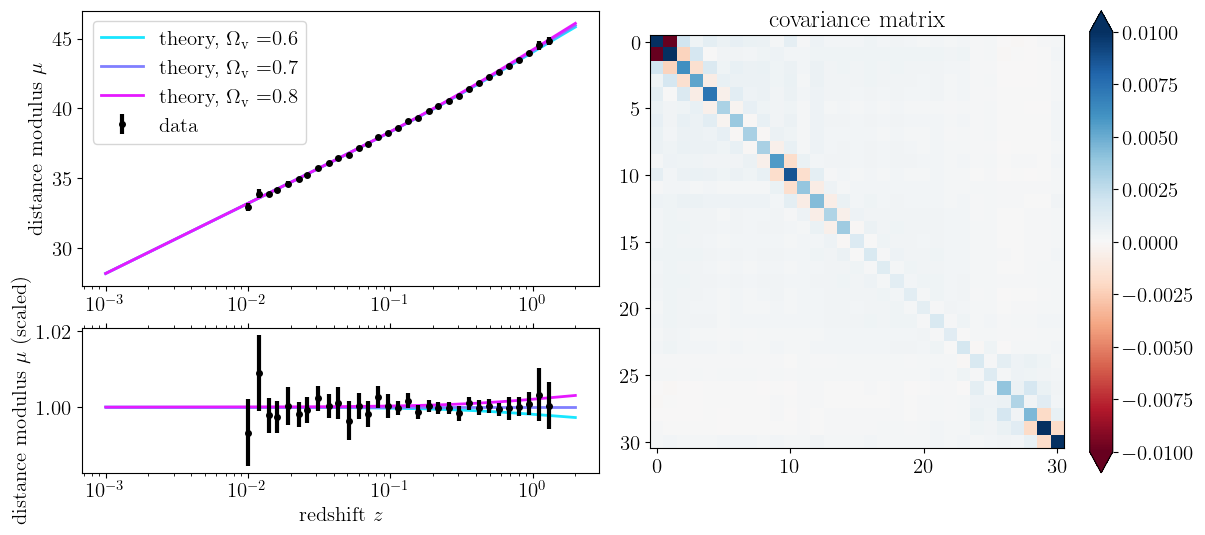

In [64]:
fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(wspace=0.1)
spec = fig.add_gridspec(2, 2, height_ratios=[1.9, 1])
ax0a = fig.add_subplot(spec[0, 0])
ax0b = fig.add_subplot(spec[1, 0], sharex=ax0a)
ax1 = fig.add_subplot(spec[:, 1])

ax0a.set_xscale('log')
ax0a.set_prop_cycle(cycler('color', plt.cm.cool(np.linspace(0.1, 0.9, 3))))
for Omega_v in [0.6,0.7,0.8]:
    ax0a.plot(zs,mus[Omega_v],label="theory, $\Omega_\mathrm{v}=$"+str(Omega_v))
ax0a.errorbar(zdata,data,2*np.sqrt(np.diagonal(cov)),ls="",lw=3,marker="o",ms=4,color="black",label="data")

ax0a.set_ylabel("distance modulus $\mu$")
ax0a.legend(loc="best")
ax0b.set_xlabel("redshift $z$")

ax0b.set_prop_cycle(cycler('color', plt.cm.cool(np.linspace(0.1, 0.9, 3))))
for Omega_v in [0.6,0.7,0.8]:
    ax0b.plot(zs,mus[Omega_v]/mus[0.7],label="theory, $\Omega_\mathrm{m}=$"+str(Omega_m))
ax0b.errorbar(zdata,data/mu3(zdata,Omega_m=Omega_m,h=h,Omega_v=0.7),2*np.sqrt(np.diagonal(cov))/mu3(zdata,Omega_m=Omega_m,h=h,Omega_v=0.7),ls="",lw=3,marker="o",ms=4,color="black",label="data")
ax0b.set_xlabel("redshift $z$")
ax0b.set_ylabel("distance modulus $\mu$ (scaled)")
ax0b.tick_params(axis='x', which='both', bottom=True, top=True)

im = ax1.imshow(cov,cmap="RdBu",vmin=-0.01,vmax=0.01,interpolation="nearest")
ax1.set_title("covariance matrix")
plt.colorbar(im, ax=ax1, extend="both")

plt.savefig(dir+'Supernova_theory_data_covmat_Omegav.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_theory_data_covmat_Omegav.png',dpi=300,bbox_inches="tight")
plt.show()

### Theory: interpolation

In [65]:
from scipy.interpolate import RegularGridInterpolator
x = np.linspace(1e-4, 1., 100)
y = np.linspace(1e-4, 1., 100)
xx, yy = np.meshgrid(x, y)
z = np.array([[D_L3(zdata,xi,yi) for xi in x] for yi in y])
f = {}
for n in range(len(zdata)):
    f[n] = RegularGridInterpolator((y, x), z[:, :, n])

def D_L3_interp(Omega_m, Omega_v):
    point = np.array([[Omega_v, Omega_m]])
    return np.array([f[n](point)[0] for n in range(len(zdata))])

def mu3_interp(Omega_m, h, Omega_v):
    return 25. - 5.*np.log10(h) + 5.*np.log10(D_L3_interp(Omega_m, Omega_v))

In [66]:
print("true mu3: {}".format(mu3(zdata,0.2,0.7,0.85)))
print("interpolated mu3: {}".format(mu3_interp(0.2,0.7,0.85)))
print("max error: {}".format(np.abs(mu3(zdata,0.2,0.7,0.85) - mu3_interp(0.2,0.7,0.85)).max()))

true mu3: [33.17899561 33.57864895 33.9171205  34.21080835 34.5895509  35.01182182
 35.28357467 35.67467887 36.06979813 36.40696897 36.79180118 37.16065082
 37.51289302 37.87719862 38.26747049 38.64645833 39.03004103 39.42588432
 39.82324253 40.2154906  40.62846866 41.03998394 41.45925523 41.89000936
 42.32139557 42.76532817 43.2096594  43.66388846 44.12157076 44.57965953
 45.04117174]
interpolated mu3: [33.17899561 33.57864896 33.9171205  34.21080835 34.58955091 35.01182183
 35.28357468 35.67467889 36.06979816 36.406969   36.79180123 37.16065089
 37.51289312 37.87719875 38.26747068 38.64645858 39.03004139 39.42588483
 39.82324324 40.21549157 40.62847003 41.03998586 41.4592579  41.89001309
 42.32140073 42.7653353  43.20966909 43.66390154 44.12158811 44.57968205
 45.04120034]
max error: 2.8596597665853096e-05


### Log-likelihood and log-posterior

In [67]:
def target_lh3(theta,data,cov,Ncalls=-1):
    Omega_m, h, Omega_v = theta[0], theta[1], theta[2]

    # Likelihood part
    theory = mu3_interp(Omega_m,h,Omega_v)
    ans = ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

def target_logpdf3(theta,data,cov,Ncalls=-1):
    Omega_m, h, Omega_v = theta[0], theta[1], theta[2]

    # Prior part
    theta_mean = np.array([0.3,0.7,0.7])
    theta_cov = np.array([[0.1**2,0,0],[0,0.1**2,0],[0,0,0.1**2]])
    ans = ss.multivariate_normal.logpdf(theta,mean=theta_mean,cov=theta_cov)

    # Likelihood part
    theory = mu3_interp(Omega_m,h,Omega_v)
    ans += ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [68]:
h=0.7
Omega_m=0.3
Omega_v=0.7
theta=np.array([Omega_m,h,Omega_v])
Math(f"\\mathrm{{log-likelihood}}(\\Omega_m={Omega_m:.1f}, h={h:.1f}, \\Omega_\Lambda={Omega_v:.1f}) = {target_lh3(theta,data,cov):.3f}")

<IPython.core.display.Math object>

In [69]:
h=0.7
Omega_m=0.3
Omega_v=0.8
theta=np.array([Omega_m,h,Omega_v])
Math(f"\\mathrm{{log-likelihood}}(\\Omega_m={Omega_m:.1f}, h={h:.1f}, \\Omega_\Lambda={Omega_v:.1f}) = {target_lh3(theta,data,cov):.3f}")

<IPython.core.display.Math object>

### Metropolis-Hastings sampler

In [70]:
def proposal_pdf3(proposal_cov):
    # We introduce correlations or anti-correlations between parameters in the proposal covariance matrix
    return ss.multivariate_normal([0,0,0],proposal_cov)

In [71]:
def MH_sampler(Nsamp,theta_start,zdata,data,cov,proposal_cov):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    theta=theta_start
    for i in range(Nsamp-1):
        theta_p = theta + proposal_pdf3(proposal_cov).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        try:
            log_a = target_logpdf3(theta_p,data,cov) - target_logpdf3(theta,data,cov)
        except ValueError:
            log_a = -np.inf
        u = ss.uniform().rvs()
        if np.log(u) < log_a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
    return Naccepted, np.array(samples)

In [72]:
Nsamp=10000
Nburnin=150
# proposal_cov=np.array([[0.02**2, 0, 0],
#                        [0, 0.02**2, 0],
#                        [0, 0, 0.02**2]])
proposal_cov=np.array([[ 7.93310918e-03, -7.96384748e-05,  3.26106044e-03],
                       [-7.96384748e-05,  4.91425771e-05,  1.48500330e-04],
                       [ 3.26106044e-03,  1.48500330e-04,  3.20024093e-03]])
theta_start=np.array([0.5,0.5,0.5])
Naccepted, samples = MH_sampler(Nsamp,theta_start,zdata,data,cov,proposal_cov)
fraction_accepted=float(Naccepted)/Nsamp
fraction_accepted

0.4556

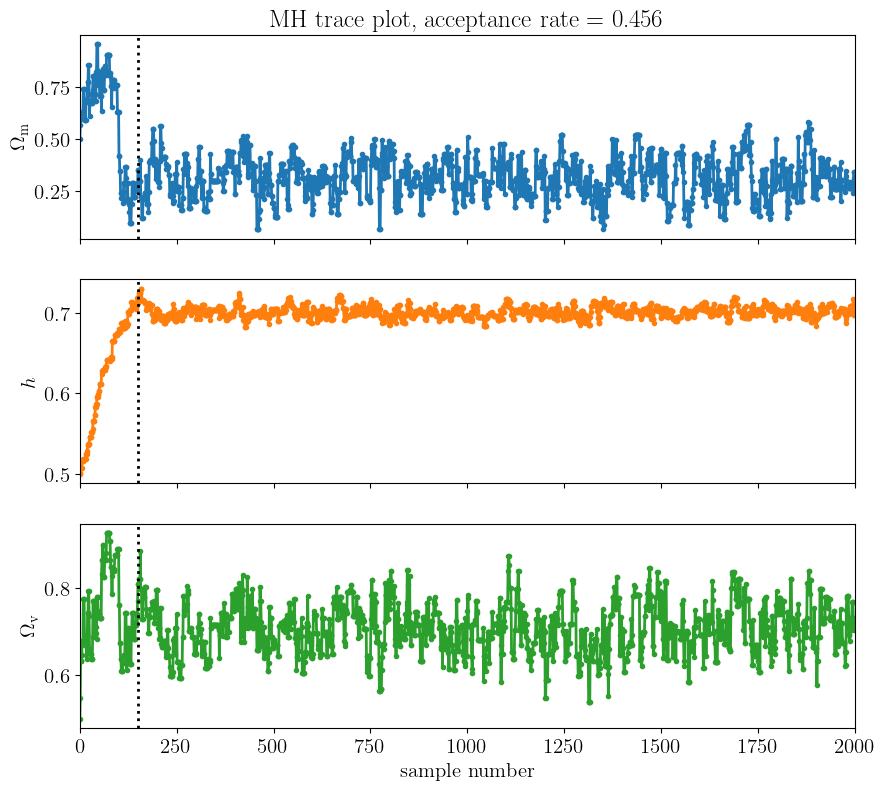

In [73]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10,9), sharex=True)
Ntrace=2000
ax0.set_title("MH trace plot, acceptance rate = {:.3f}".format(fraction_accepted))
ax0.set_xlim(0,Ntrace)
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Ntrace),samples.T[0][:Ntrace],marker='.',color='C0')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_xlim(0,Ntrace)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Ntrace),samples.T[1][:Ntrace],marker='.',color='C1')
ax1.axvline(Nburnin,color='black',linestyle=':')

ax2.set_xlim(0,Ntrace)
ax2.set_ylabel("$\Omega_\mathrm{v}$")
ax2.plot(np.arange(Ntrace),samples.T[2][:Ntrace],marker='.',color='C2')
ax2.set_xlabel("sample number")
ax2.axvline(Nburnin,color='black',linestyle=':')

plt.savefig(dir+'Supernova_MH_trace_plot_3params.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Supernova_MH_trace_plot_3params.png',dpi=300,bbox_inches="tight")
plt.show()

In [74]:
# Remove burn-in phase
samples=samples[Nburnin:,:]

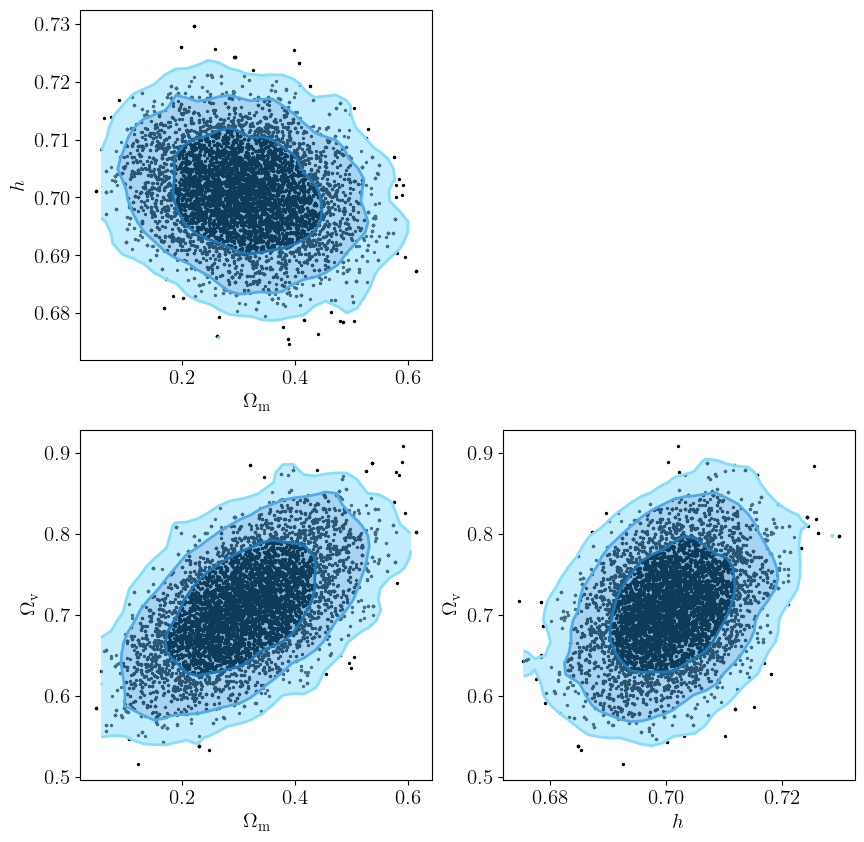

In [75]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2,2,1)
ax0.scatter(samples.T[0], samples.T[1], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours_from_samples(samples.T[0], samples.T[1])
nContourLevels = len(chainLevels)
ax0.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1], alpha=0.5)
ax0.contour(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1])
ax0.set_xlabel("$\Omega_\mathrm{m}$")
ax0.set_ylabel("$h$")

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(samples.T[0], samples.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours_from_samples(samples.T[0], samples.T[2])
nContourLevels = len(chainLevels)
ax1.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1], alpha=0.5)
ax1.contour(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1])
ax1.set_xlabel("$\Omega_\mathrm{m}$")
ax1.set_ylabel("$\Omega_\mathrm{v}$")

ax2 = fig.add_subplot(2,2,4)
ax2.scatter(samples.T[1], samples.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours_from_samples(samples.T[1], samples.T[2])
nContourLevels = len(chainLevels)
ax2.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1], alpha=0.5)
ax2.contour(xbins, ybins, contours, levels=chainLevels,
    colors=colors[0][:nContourLevels][::-1])
ax2.set_xlabel("$h$")
ax2.set_ylabel("$\Omega_\mathrm{v}$")

plt.show()

In [76]:
# Compute the posterior covariance, which can be fed back to the sampler as proposal covariance
np.cov(samples.T)

array([[ 8.12849232e-03, -1.31937137e-04,  2.90047850e-03],
       [-1.31937137e-04,  5.00041374e-05,  1.41300112e-04],
       [ 2.90047850e-03,  1.41300112e-04,  3.07007640e-03]])